In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [3]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


# 랜덤 포레스트

In [5]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9237


In [19]:
params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 ) # n_job=-1 현재 모든 CPU를 활용한다는 뜻. 
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was exp

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was exp

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was exp

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9181


In [20]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9169


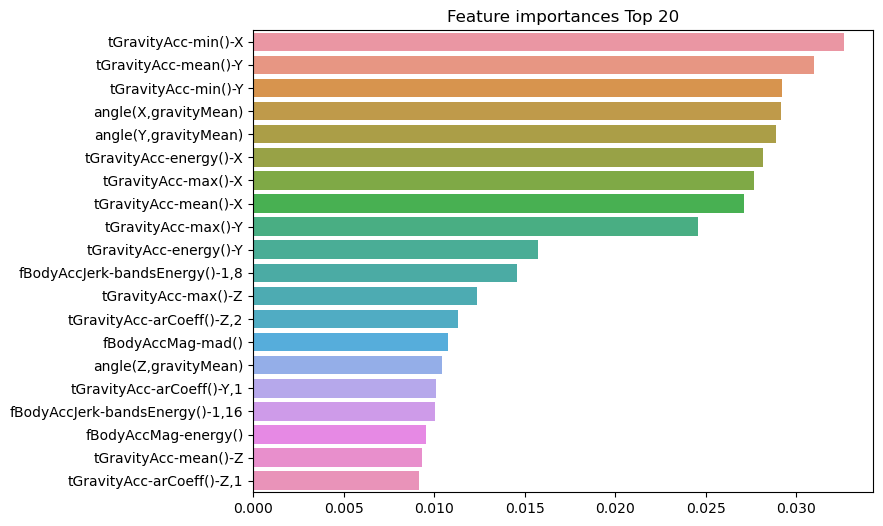

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

# 로지스틱 회귀

In [21]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('로지스틱 회귀 정확도: {0:.4f}'.format(accuracy))

로지스틱 회귀 정확도: 0.9576


In [22]:
params = {
    'C': [0.01, 0.1, 1, 10, 100],  # 역수값 (작을수록 규제가 강함)
}

# GridSearchCV 수행
grid_cv = GridSearchCV(lr_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적 하이퍼 파라미터 및 정확도 출력
print('로지스틱 회귀 최적 하이퍼 파라미터:', grid_cv.best_params_)
print('로지스틱 회귀 최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array w

로지스틱 회귀 최적 하이퍼 파라미터: {'C': 1}
로지스틱 회귀 최고 예측 정확도: 0.9306


In [18]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('로지스틱 회귀 예측 정확도: {0:.4f}'.format(accuracy))

로지스틱 회귀 예측 정확도: 0.9576


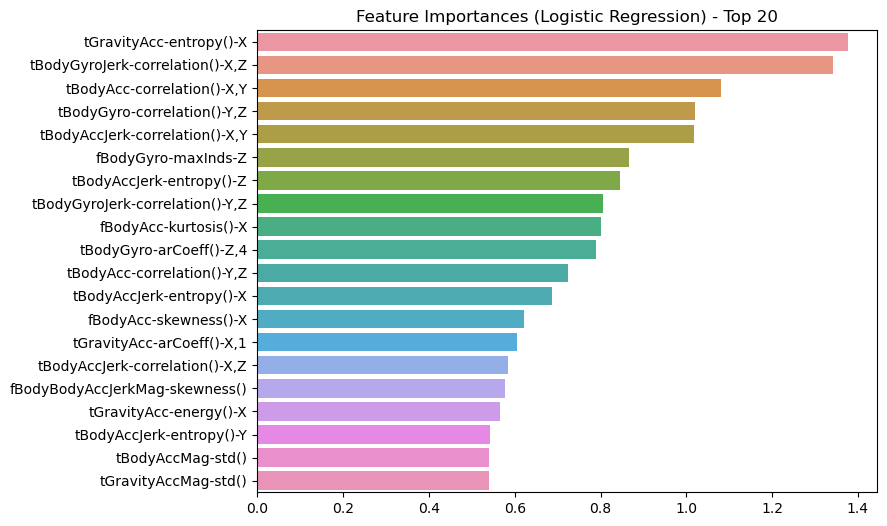

In [30]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# 피처 중요도 추출
ftr_importances_values = lr_clf.coef_[0]
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.abs().sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8, 6))
plt.title('Feature Importances (Logistic Regression) - Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 의사결정 트리

In [23]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('의사결정 트리 정확도: {0:.4f}'.format(accuracy))

의사결정 트리 정확도: 0.8595


In [24]:
params = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

# GridSearchCV 수행
grid_cv = GridSearchCV(dt_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적 하이퍼 파라미터 및 정확도 출력
print('의사결정 트리 최적 하이퍼 파라미터:', grid_cv.best_params_)
print('의사결정 트리 최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

의사결정 트리 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8}
의사결정 트리 최고 예측 정확도: 0.8466


In [25]:
dt_clf = DecisionTreeClassifier()

# 모델 학습
dt_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
pred = dt_clf.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, pred)
print('의사결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

의사결정 트리 예측 정확도: 0.8554


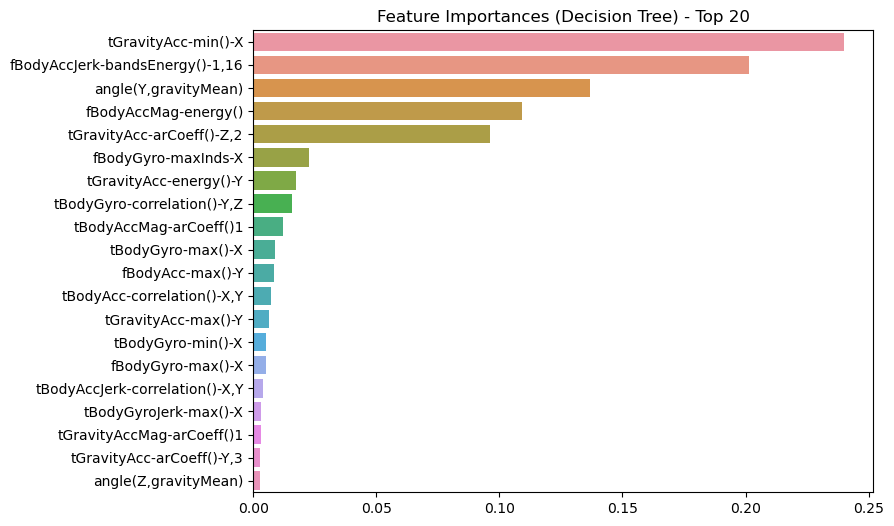

In [31]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

# 피처 중요도 추출
ftr_importances = dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8, 6))
plt.title('Feature Importances (Decision Tree) - Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 서포트 벡터 머신

In [27]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=0)
svm_clf.fit(X_train, y_train)
pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('서포트 벡터 머신 정확도: {0:.4f}'.format(accuracy))

서포트 벡터 머신 정확도: 0.9505


In [28]:
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# GridSearchCV 수행
grid_cv = GridSearchCV(svm_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적 하이퍼 파라미터 및 정확도 출력
print('서포트 벡터 머신 최적 하이퍼 파라미터:', grid_cv.best_params_)
print('서포트 벡터 머신 최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array w

서포트 벡터 머신 최적 하이퍼 파라미터: {'C': 10, 'kernel': 'rbf'}
서포트 벡터 머신 최고 예측 정확도: 0.9355


In [29]:
svm_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
pred = svm_clf.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, pred)
print('서포트 벡터 머신 예측 정확도: {0:.4f}'.format(accuracy))

서포트 벡터 머신 예측 정확도: 0.9505


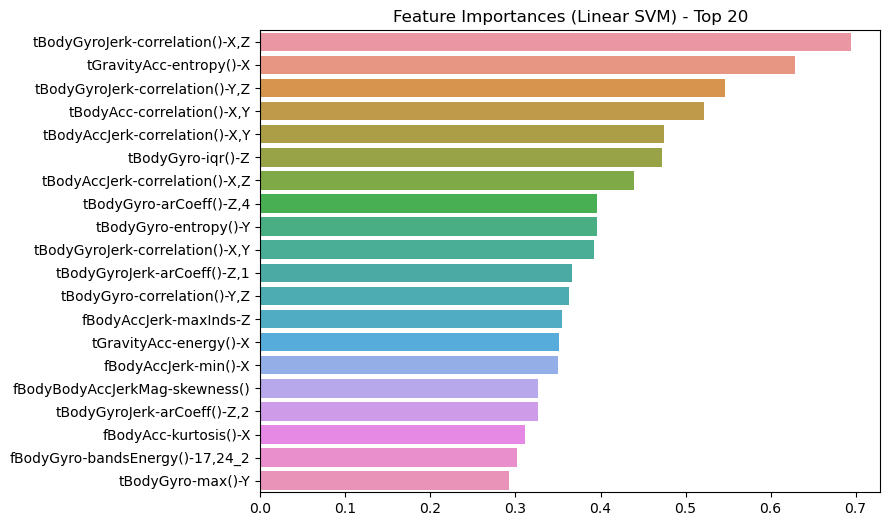

In [33]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

# 피처 중요도 확인
ftr_importances = svm_clf.coef_[0]
ftr_top20 = pd.Series(ftr_importances, index=X_train.columns).abs().sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8, 6))
plt.title('Feature Importances (Linear SVM) - Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()